In [50]:
import numpy as np
import pandas as pd

import matplotlib, matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KernelDensity

# from xgboost.sklearn import XGBClassifier as XGBC

# from bayes_opt import BayesianOptimization
import scipy
from scipy import stats
import statsmodels.api as sm

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, MiniBatchSparsePCA
from sklearn.manifold import TSNE
import sweetviz as sv
from sklearn.decomposition import KernelPCA

### Vizualizing Raw data to check missing data and possible correlations

In [3]:
dataset = pd.read_csv("data/CHES2019_experts.csv")

In [4]:
chapel_hill_survey = sv.analyze(dataset)
chapel_hill_survey.show_html("chapel_hill_survey.html")


Report chapel_hill_survey.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Part I Preprocessing Data

In [5]:
df = pd.read_csv("data/CHES2019_experts.csv")

#### Dropping columns that have large missing values

In [6]:
# dropping >95% missing data columns
df.drop(columns = ["eu_econ_require", "eu_political_require", "eu_googov_require"], inplace=True)

In [7]:
#dropping party_name column as we have the unique identifier party_id
df.drop(columns="party_name", inplace=True)

In [8]:
# making party_id as a target as we want to represent political parties in two dimensions
target = df["party_id"]

In [9]:
#dropping cname, eu_position_sd, lrecon_sd, galtan_sd > 50% values missing
df.drop(columns=["cname", "eu_position_sd", "lrecon_sd", "galtan_sd"], inplace=True)

#### Replacing the value ".d" with mode (most frequent values)

In [10]:
#replacing all the columns that have value ".d" with mode (most frequent value)
for col in df.columns:
    df[col].loc[df[col] == ".d"] = df[col].mode()

/Users/stuti/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Feature engineering
1. Separating the column "gender" and "dob": the preprocessing needs to be different than other columns
2. Dropping the columns following columns:

    a. "id": It is unclear in the documentation what it represents
    
    b. "party": we are interested in the party projections, so there is no requirement to keep additional information for the same
    
    c. "party_id": since it is a target so it is not included in the feature matrix

In [11]:
features = df.drop(columns=["id", "party", "party_id", "gender", "dob"])

#### Preprocessing the "dob" 
Binning the date of birth column: Range = [1933, 1995]

1930 - 1940: 0 

1940 - 1950: 2

.
.
.

1990 - 2000: 6


In [12]:
df["dob_bins"] = pd.cut(x = df["dob"], bins = [1930.0, 1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0, 2000.0], 
                        labels=range(7))

In [13]:
# filling missing values with mode (most frequent values)
df["gender"].fillna(df["gender"].mode()[0], inplace=True)

In [14]:
# imputating the missing values with mode
df["dob_bins"].fillna(df["dob_bins"].mode()[0], inplace=True)

In [15]:
# concatenating the column "dob" and "gender" to the feature matrix
features = pd.concat([features, df["gender"], df["dob_bins"]], axis = 1)

#### Impute missing data
1) for categorical data (object or ints), use the most frequent value (mode)

2) for continuous values (floats), use the median

In [16]:
for column in features.columns:
    if features[column].dtype == "object" or features[column].dtype == 'int64':
        features[column].fillna(features[column].mode()[0], inplace=True)
    elif features[column].dtype == "float64":
        features[column].fillna(features[column].median(), inplace=True)

# Part II Dimensionality Reduction

1. Since, the scale of data is not uniform therefore, scaling the data to  a uniform range with the help of StandardScaler()

2. Perform dimensionality reduction using Principal Component Analysis (PCA)

In [17]:
#scaling using standard scalar
data_scaler = preprocessing.StandardScaler()
data_scaler.fit(features)

StandardScaler()

In [18]:
scaled_data_frame = data_scaler.transform(features)

In [20]:
pca_2 = PCA(n_components=2).fit(scaled_data_frame)
df_pca_2 = pca_2.transform(scaled_data_frame)

In [21]:
print(pca_2.explained_variance_ratio_)

[0.21268321 0.10649313]


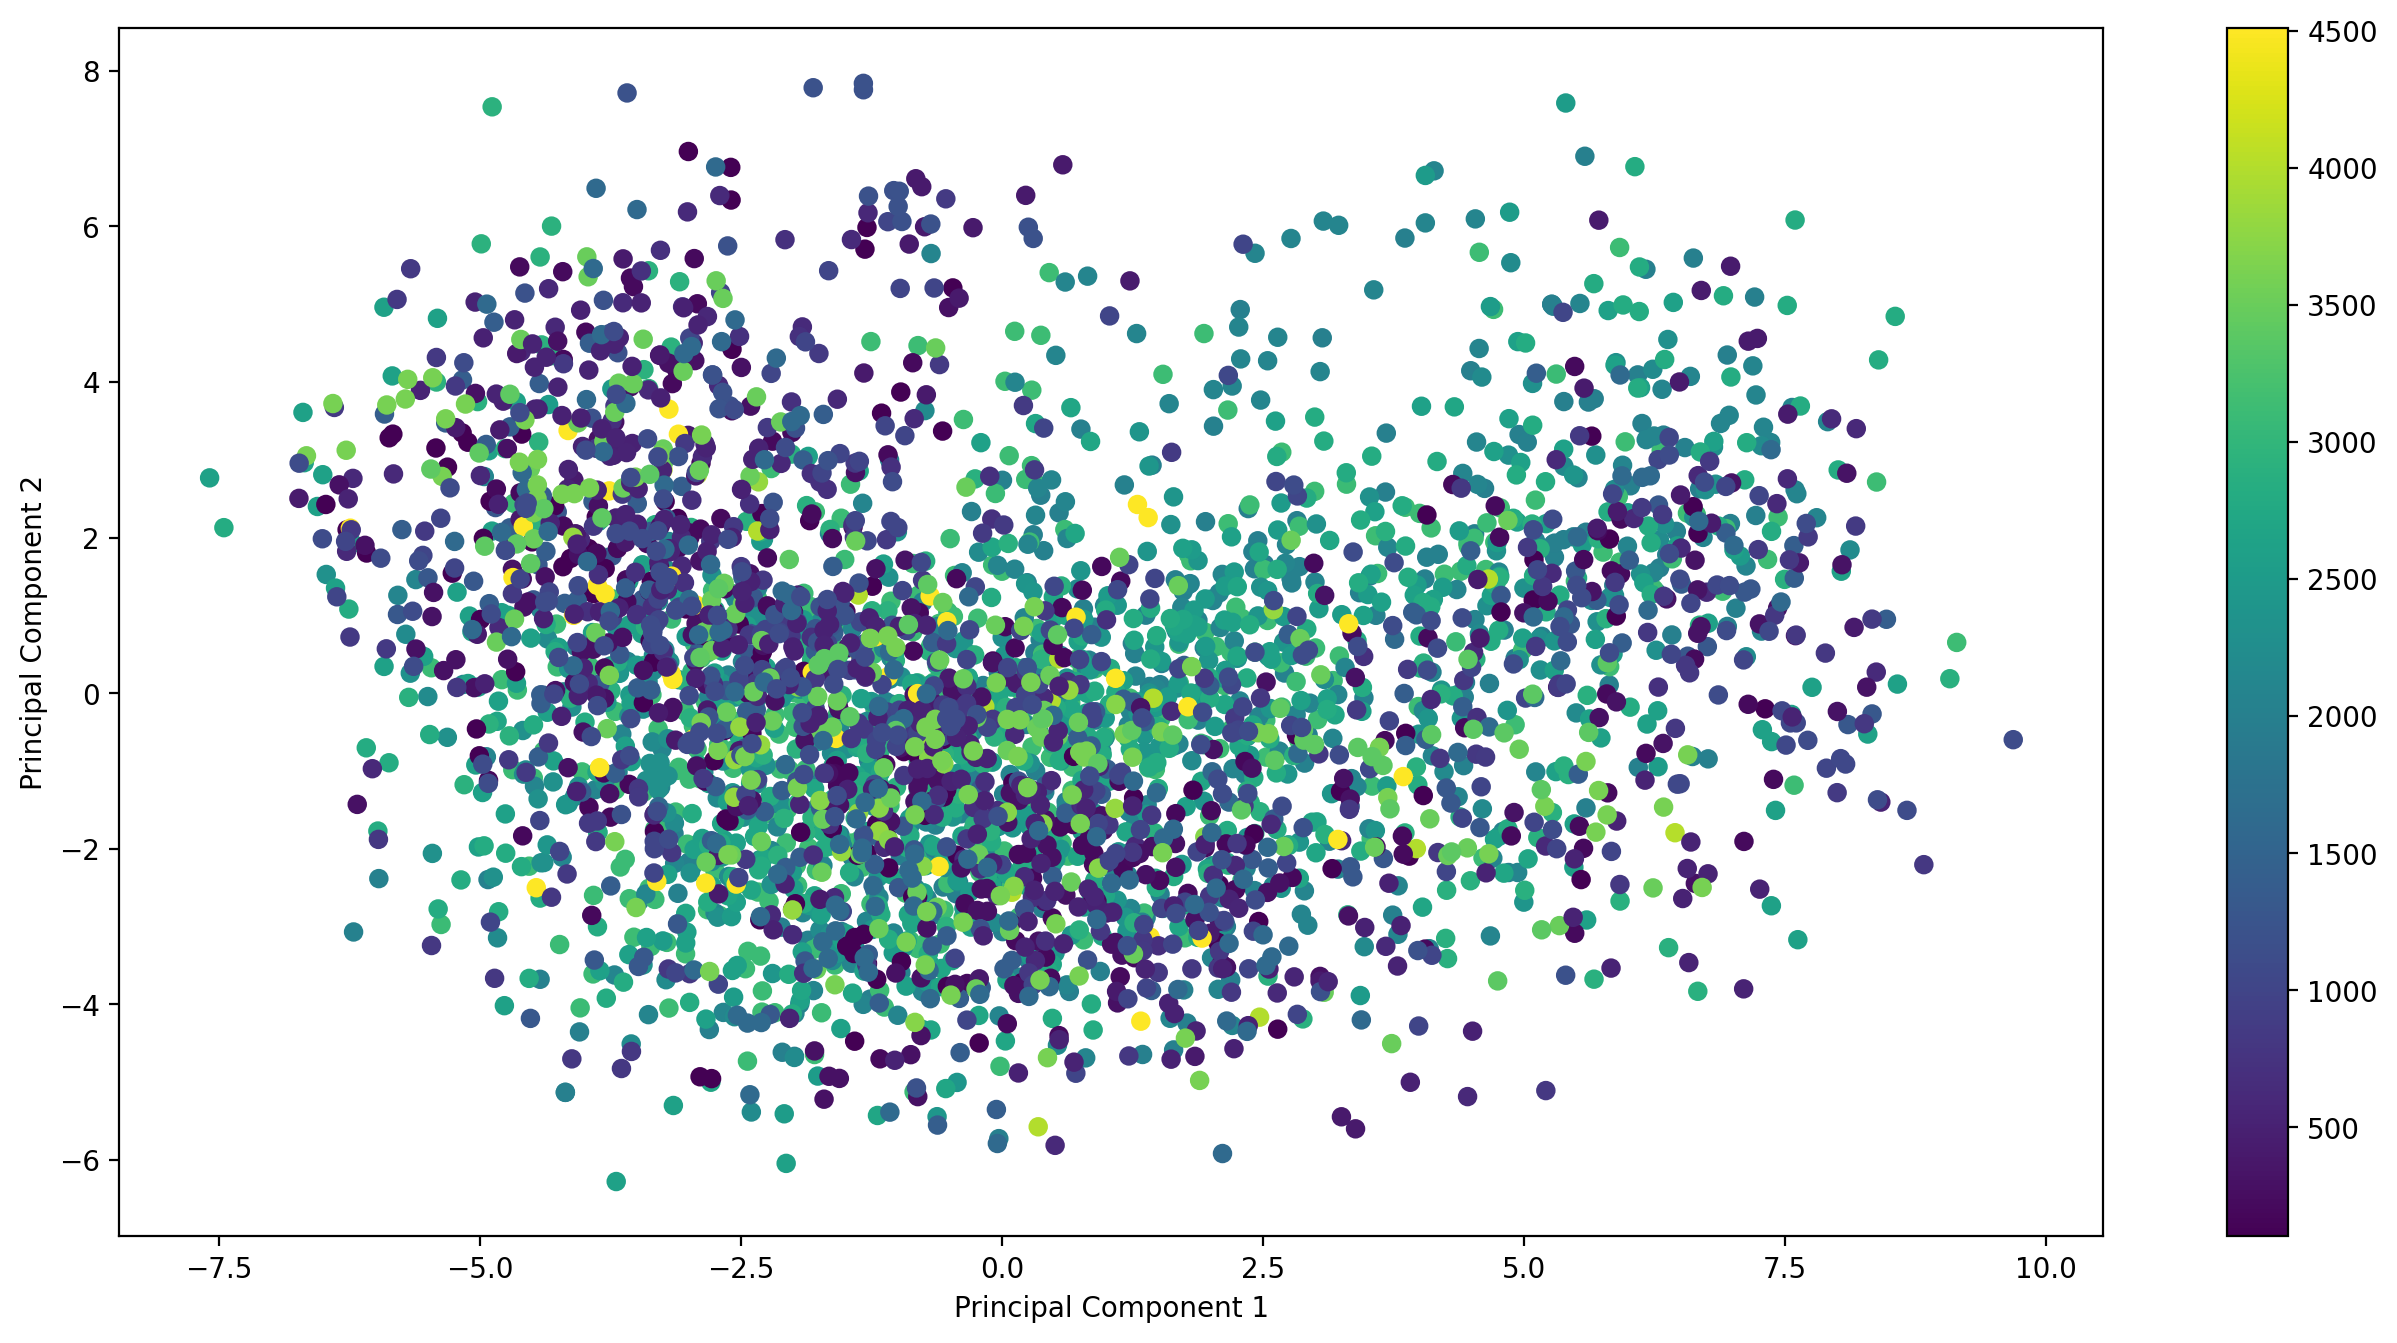

In [36]:
plt.figure(figsize = (16,8))
plt.scatter(df_pca_2[:, 0], df_pca_2[:, 1], c = target)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()

#### Gathering the most important feature on EACH component
In order to understand what factors matter the most in the political landscape

In [23]:
n_pcs = pca_2.components_.shape[0]

In [24]:

most_important = [np.abs(pca_2.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = features.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
pc_df = pd.DataFrame(dic.items())
pc_df

,0,1
0,PC0,nationalism
1,PC1,deregulation


In [25]:
tsne = TSNE(n_components=2).fit(scaled_data_frame)

X_embedded = tsne.fit_transform(scaled_data_frame)

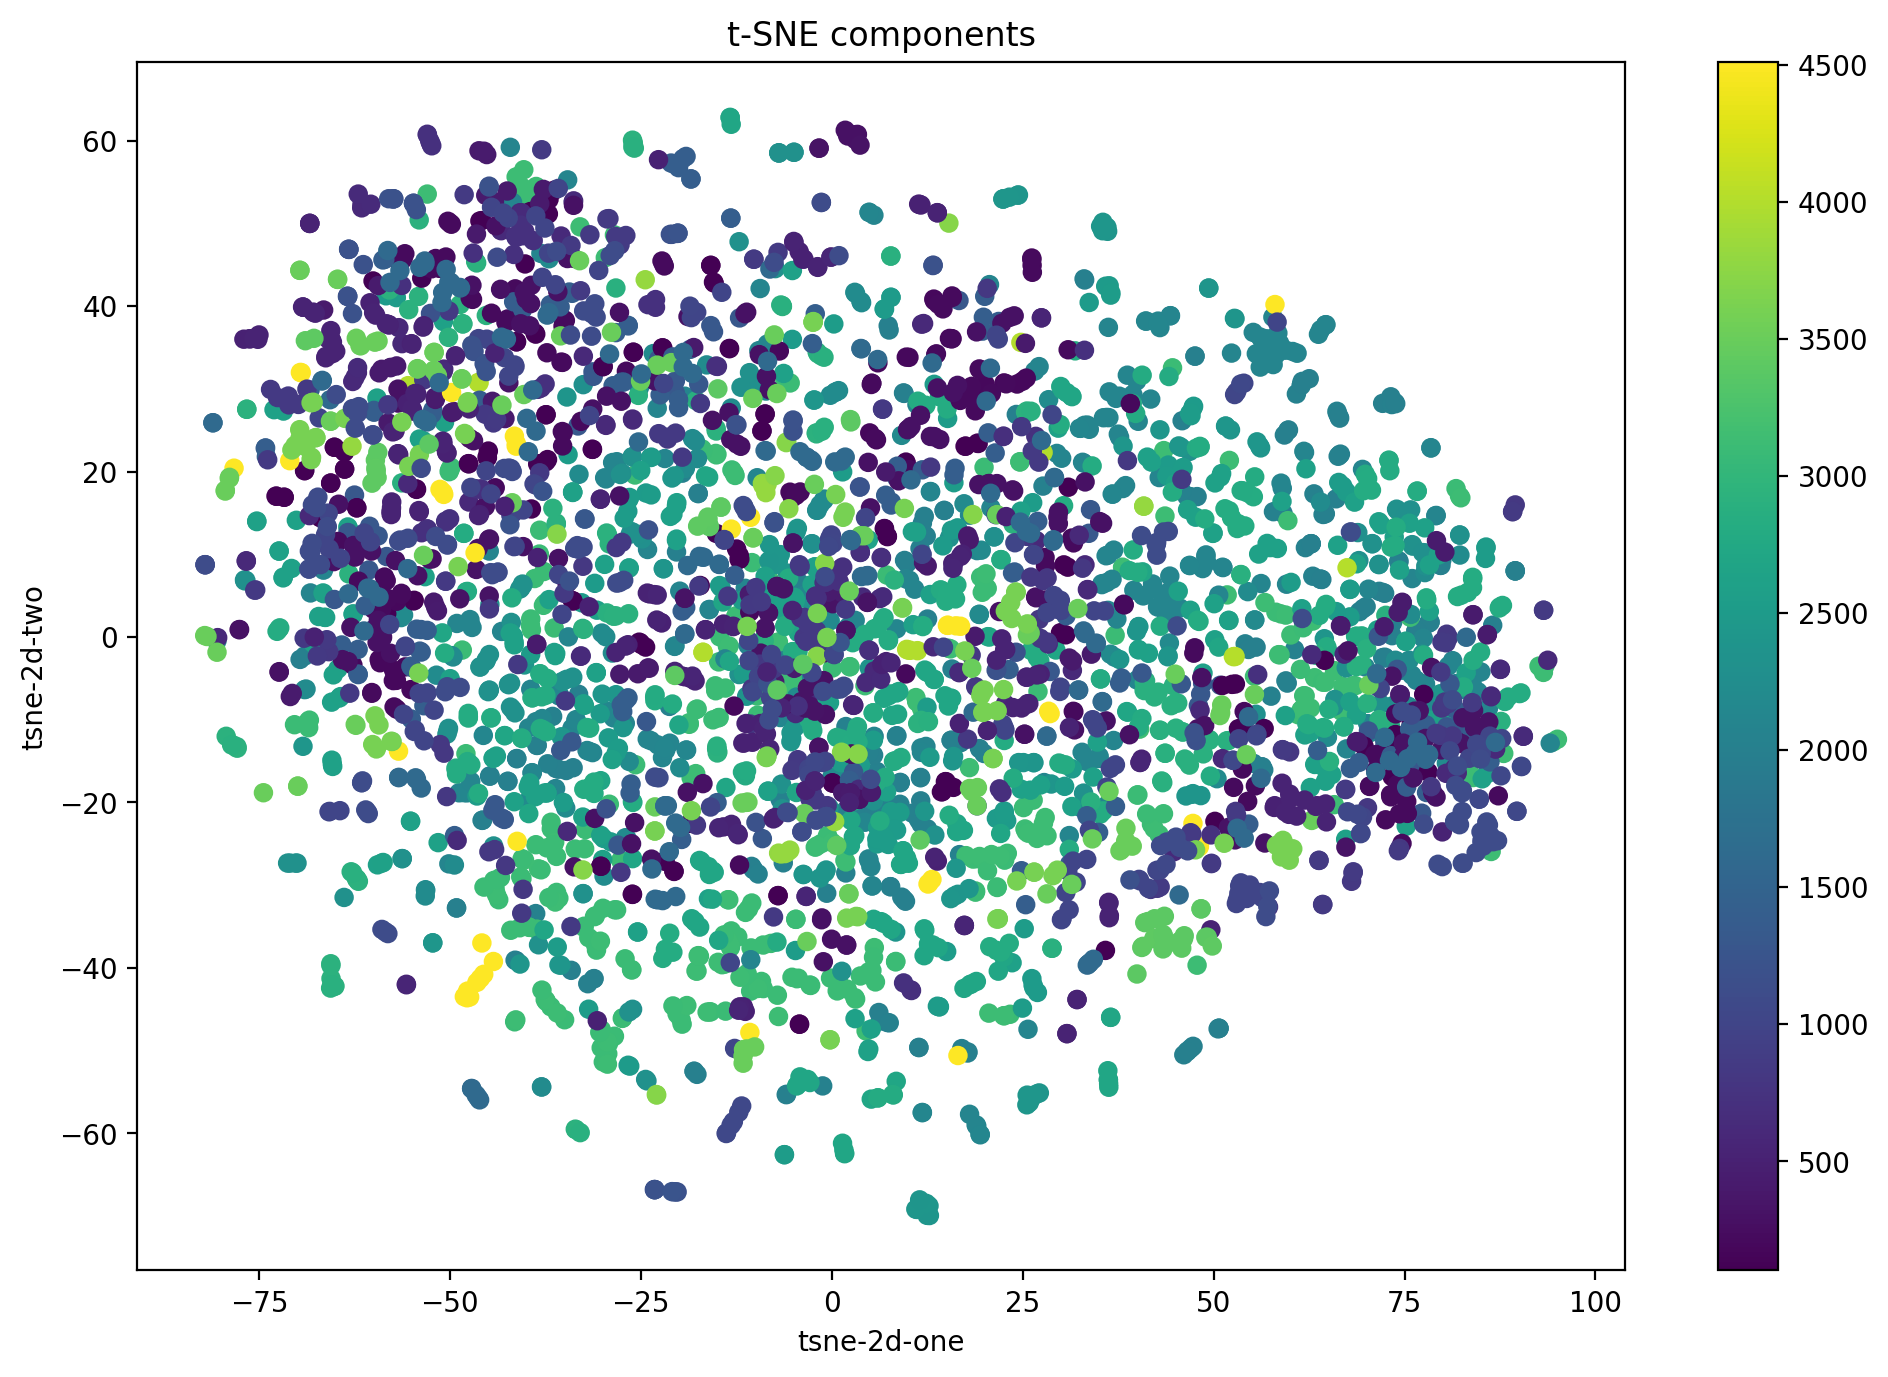

In [37]:
plt.figure(figsize=(12,8))
plt.title('t-SNE components')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = target)
plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")
plt.colorbar()

#### (Extra analysis) Feature Selection for iterating over again (when needed to reproduce for a better projection estimate)
1. trying to do feature importance using Random Forest classifier 

2. Select some features based on feature importances indicated by an unparameterized (to avoid overfitting) and hence, sub-optimal random forest 

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(features,target)

In [28]:
# print importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(features.shape[1]):
    print( (f + 1, features.columns[indices[f]], importances[indices[f]]))

Feature ranking:
(1, 'regions', 0.02799826502847872)
(2, 'corrupt_salience', 0.027770954966933763)
(3, 'eu_salience', 0.025916867125613058)
(4, 'people_vs_elite', 0.02511077616378006)
(5, 'religious_principles', 0.024822071696857934)
(6, 'urban_rural', 0.024749250397855013)
(7, 'lrgen', 0.024630344943072716)
(8, 'antielite_salience', 0.023986651924272295)
(9, 'enviro_salience', 0.023603035876608086)
(10, 'members_vs_leadership', 0.02297640443377104)
(11, 'lrecon', 0.022927850627135933)
(12, 'lrecon_salience', 0.022759493411836907)
(13, 'position', 0.02220739699026786)
(14, 'galtan', 0.022186755284651163)
(15, 'ethnic_minorities', 0.021933016761125565)
(16, 'russian_interference', 0.02193222574772309)
(17, 'lrecon_self', 0.02182326685781496)
(18, 'environment', 0.02152028320910342)
(19, 'sociallifestyle', 0.021251713650173497)
(20, 'immigra_salience', 0.021065438987644923)
(21, 'galtan_salience', 0.02102073724522783)
(22, 'econ_interven', 0.020915039404374593)
(23, 'immigrate_policy', 0

# Part III Fitting a distribution

#### Kernel Density Estimation 2D
* For estimating a distribution of the 2D points from the dimensionality reduction you need to see the probability distribution of those points

In [29]:
def kde2D(x, y, bandwidth, xbins=128j, ybins=128j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)
    
    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [30]:
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(df_pca_2)

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])})

In [31]:
print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

best bandwidth: 0.5455594781168519


In [32]:
x_ax, y_ax = df_pca_2[:,1] + df_pca_2[:,0], df_pca_2[:,0] - df_pca_2[:,1]
xx, yy, zz = kde2D(x_ax, y_ax, grid.best_estimator_.bandwidth)

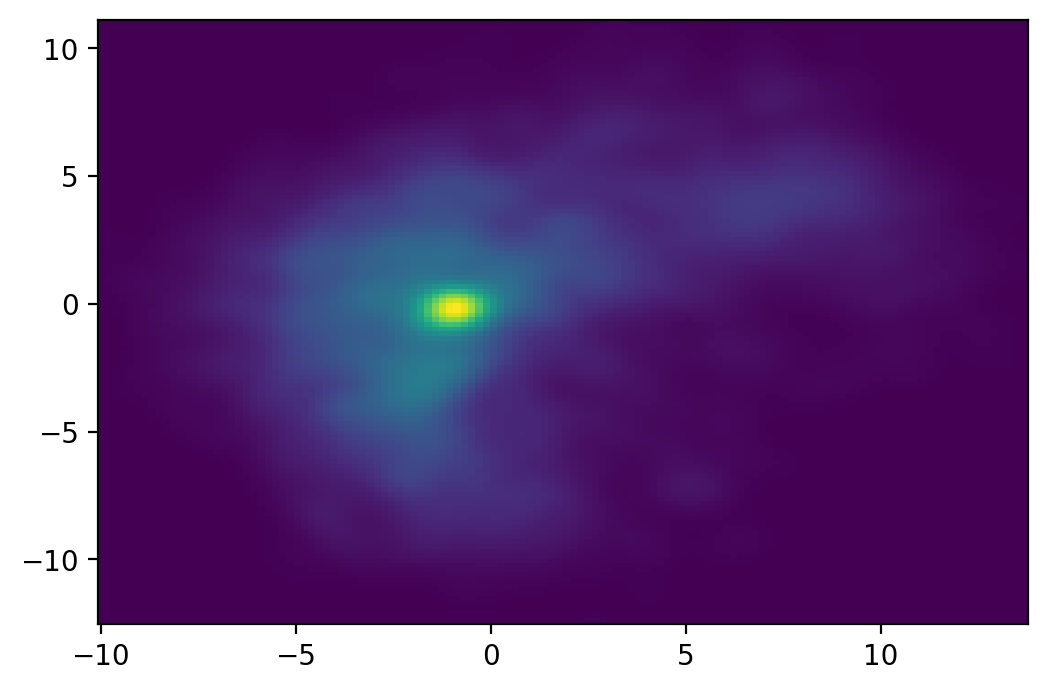

In [38]:
plt.pcolormesh(xx, yy, zz, shading="auto")
# plt.scatter(x_ax, y_ax, s=2, facecolor='white')

In [39]:
kde = grid.best_estimator_

In [40]:
kde

KernelDensity(bandwidth=0.5455594781168519)

In [34]:
plt.rcParams['figure.dpi'] = 200

### Fitting and contouring a Gaussian Kernel Density Estimation

In [41]:
# Extract x and y
xaxis = df_pca_2[:, 0]
yaxis = df_pca_2[:, 1]
# Define the borders
deltaX = (max(xaxis) - min(xaxis))/10
deltaY = (max(yaxis) - min(yaxis))/10
xmin = min(xaxis) - deltaX
xmax = max(xaxis) + deltaX
ymin = min(yaxis) - deltaY
ymax = max(yaxis) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
x_x, y_y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

-9.317797242978955 11.410783696893391 -7.687659384475429 9.250576764774001


In [42]:
positions = np.vstack([x_x.ravel(), y_y.ravel()])
values = np.vstack([xaxis, yaxis])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, x_x.shape)

Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

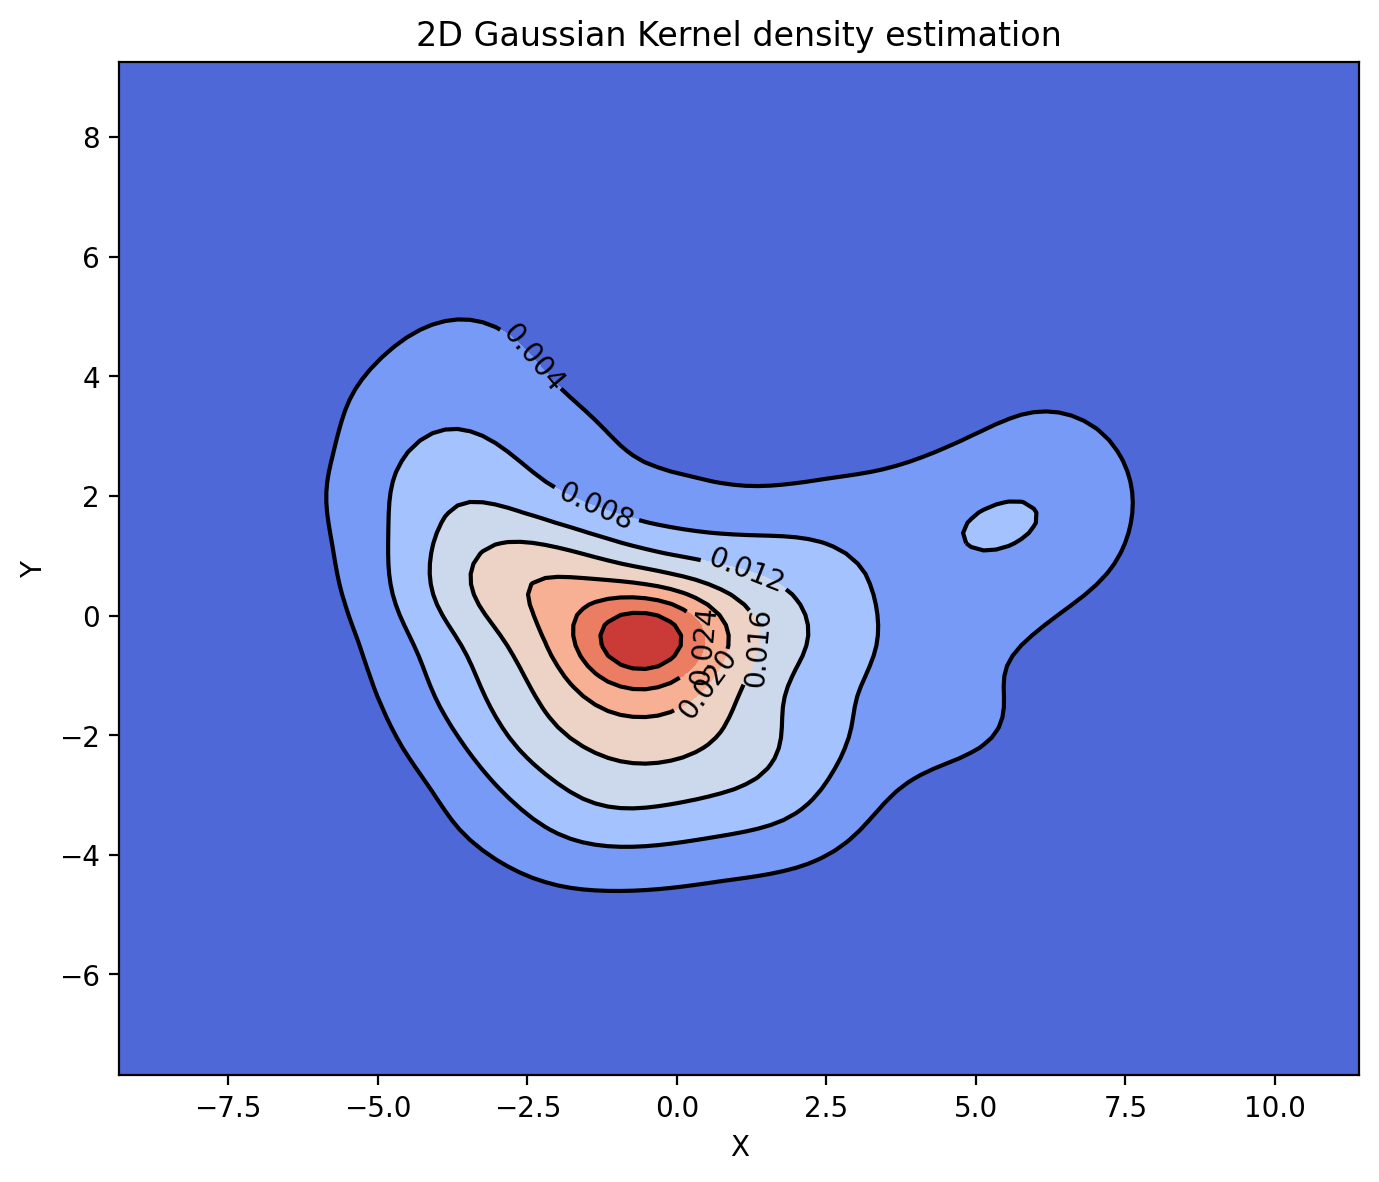

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(x_x, y_y, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(x_x, y_y, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')

#### Rendering the distribution in 3D

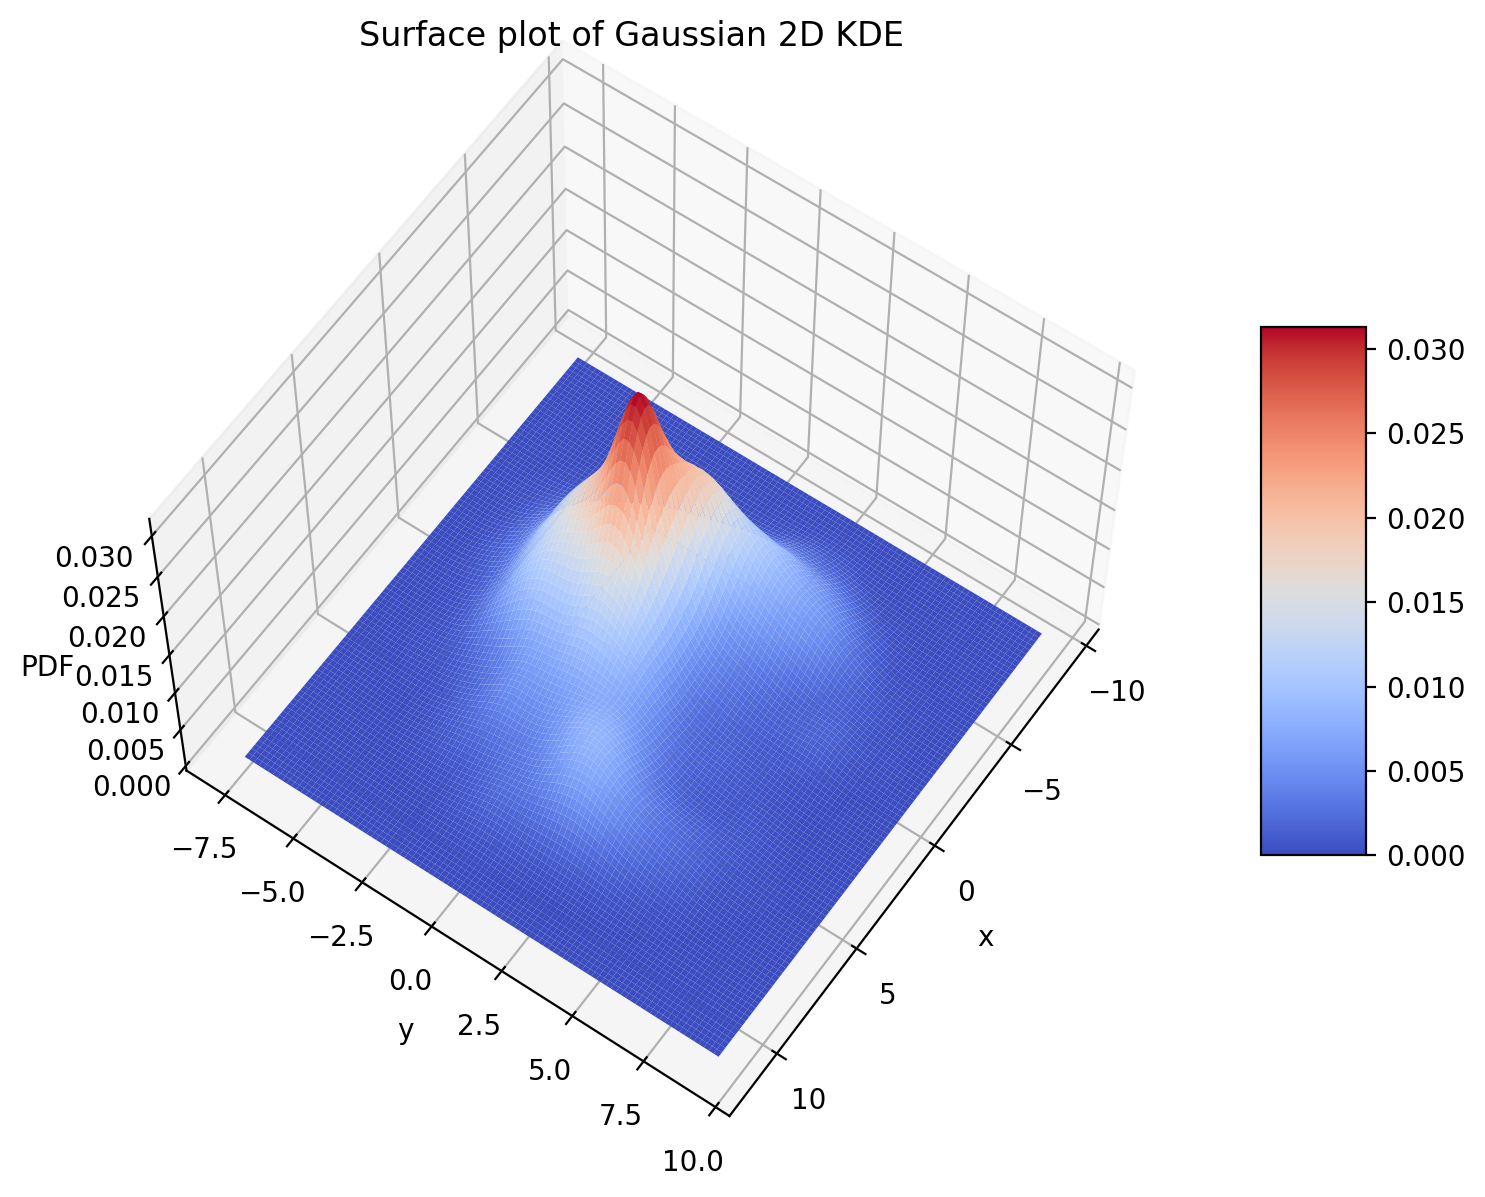

In [44]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(x_x, y_y, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)

# Part IV Random Sampling 

In [45]:
#sampling using kde
z = kde.fit(df_pca_2)
sampled_data = z.sample(10, random_state=0)
sampled_data = pca_2.inverse_transform(sampled_data)

In [46]:
sampled_data

array([[ 4.37035446e-01,  1.74364008e-01, -3.95459106e-02,
        -1.07935206e-01,  7.91628295e-01, -2.34606350e-02,
         4.39355952e-02,  8.87808901e-02,  6.65135882e-02,
         1.58205273e-01,  1.16990101e-01, -9.15672621e-02,
         5.10929455e-01,  1.26079769e-01, -1.41930624e-01,
         2.01011337e-01,  1.33892064e-01, -1.19538951e-01,
         1.88287208e-01,  7.72049385e-01, -3.21988311e-01,
         2.99076010e-01, -1.86497856e-01,  7.43374769e-01,
         8.24751957e-01,  8.21383842e-01,  1.00968556e-01,
         3.59471645e-02,  1.64132826e-01,  9.38260269e-02,
        -5.70382100e-03, -6.76791010e-02, -6.41434539e-01,
        -6.58890933e-02,  6.34538623e-02, -1.13824188e-01,
        -3.93963269e-01, -4.33594477e-01, -1.11981327e-01,
         8.08331162e-02,  1.81761397e-01,  4.40943326e-01,
         5.63127193e-01,  4.80168304e-01,  2.40456547e-01,
         1.33501482e-02,  2.92961141e-03, -5.82683704e-03,
        -2.37141278e-02,  4.33113083e-02, -2.37826106e-0

In [47]:

# feature values from the high-dimensional space that map to the sampled_data
pd.DataFrame(sampled_data,columns= features.columns)

,position,eu_salience,eu_dissent,eu_blur,lrecon,lrecon_blur,lrecon_dissent,lrecon_salience,galtan,galtan_blur,...,eu_intmark,eu_budgets,eu_asylum,party_a_econ,party_b_econ,party_c_econ,lrecon_self,galtan_self,gender,dob_bins
0,0.437035,0.174364,-0.039546,-0.107935,0.791628,-0.023461,0.043936,0.088781,0.066514,0.158205,...,0.563127,0.480168,0.240457,0.013350,0.002930,-0.005827,-0.023714,0.043311,-0.023783,0.016134
1,-1.432907,-0.346101,0.073940,0.381894,-0.287708,0.303837,0.001769,-0.466705,1.215677,-0.137971,...,-1.258827,-1.323887,-1.379435,0.039277,-0.047005,-0.036282,0.066215,-0.031978,-0.010181,-0.063992
2,0.275413,-0.051354,0.014904,-0.088037,-1.150616,-0.176972,-0.076537,0.181472,-0.982853,-0.172430,...,-0.065035,0.123595,0.573982,-0.050945,0.028577,0.035915,-0.006699,-0.051347,0.048022,0.018096
3,0.203543,-0.009269,0.003929,-0.061502,-0.556909,-0.101937,-0.038022,0.111785,-0.544063,-0.079021,...,0.026639,0.123187,0.349044,-0.027091,0.016364,0.019500,-0.006418,-0.023957,0.024281,0.011963
4,1.633605,0.440795,-0.095712,-0.429646,0.800824,-0.299903,0.027859,0.496093,-1.092205,0.235301,...,1.555509,1.560626,1.451550,-0.027764,0.045926,0.030016,-0.077853,0.058999,-0.006455,0.070682
5,-0.812593,-0.130735,0.025744,0.224707,0.507304,0.238228,0.043367,-0.315687,1.105938,0.032368,...,-0.543195,-0.678012,-0.953982,0.046401,-0.037521,-0.036666,0.034199,0.013831,-0.031385,-0.039512
6,1.407283,0.404366,-0.088538,-0.367063,0.941940,-0.233570,0.039926,0.408182,-0.784291,0.244287,...,1.404173,1.371767,1.185894,-0.014846,0.035478,0.019808,-0.068327,0.062842,-0.015189,0.059678
7,0.609268,0.117321,-0.024069,-0.166085,-0.182939,-0.159207,-0.020041,0.221673,-0.706557,0.008302,...,0.457537,0.529786,0.664715,-0.027686,0.024933,0.022753,-0.026629,-0.000957,0.015990,0.028676
8,-0.642680,-0.073967,0.013091,0.181375,0.702316,0.218019,0.053323,-0.272589,1.061742,0.075273,...,-0.352964,-0.503565,-0.831616,0.047533,-0.034555,-0.036225,0.025543,0.025293,-0.036323,-0.032697
9,0.803349,0.260233,-0.057804,-0.205888,0.838483,-0.103759,0.041797,0.210123,-0.260852,0.189073,...,0.878142,0.815715,0.599937,0.002349,0.015379,0.004089,-0.040508,0.050213,-0.020160,0.032622


In [48]:
#vizualizing the sampled data
x_axis, y_axis = z.sample(10, random_state=0)[:,1] + z.sample(10, random_state=0)[:,0], z.sample(10, random_state=0)[:,0] - z.sample(10, random_state=0)[:,1]
xx_1, yy_1, zz_1 = kde2D(x_ax, y_ax, grid.best_estimator_.bandwidth)

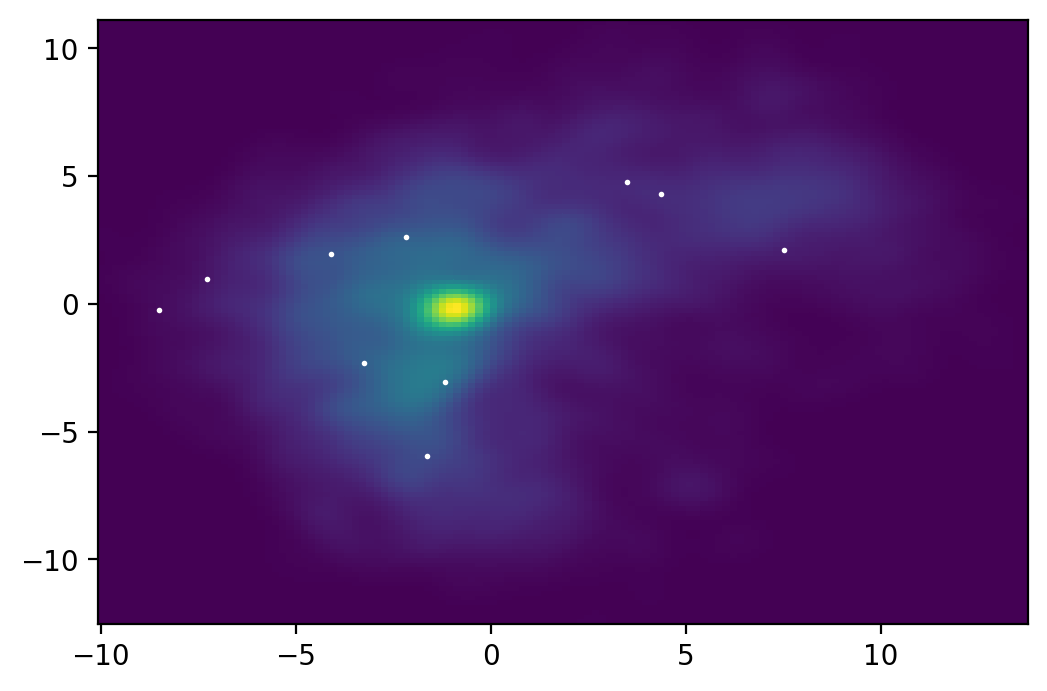

In [49]:
plt.pcolormesh(xx_1, yy_1, zz_1, shading="auto")
plt.scatter(x_axis, y_axis, s=1,facecolor='white')